In [161]:
__author__ = "Ahmed Youssef, modified by Mohammad Elnesr"
__all__ = ['Season', 'Calendar', 'Prayertime', 'Mazhab',
           'as_pytime', 'as_pydatetime']

from math import degrees, radians, atan, asin, acos, cos, sin, tan, atan2
from datetime import date, datetime, timedelta
from time import strptime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker

In [2]:
def remove_duplication(var):
    return var % 360

In [3]:
class Season(object):
    Winter, Summer = 0, 1


class Calendar(object):
    UmmAlQuraUniv, \
        EgyptianGeneralAuthorityOfSurvey,\
        UnivOfIslamicSciencesKarachi,\
        IslamicSocietyOfNorthAmerica,\
        MuslimWorldLeague = range(5)


class Mazhab(object):
    Default, Hanafi = 0, 1

In [4]:
def to_hrtime(var, isAM=False):
    """var: double -> human readable string of format "%I:%M:%S %p" """

    # time = ''
    n_time = []
    intvar = int(var)  # var is double.
    if isAM:
        if intvar % 12 and intvar % 12 < 12:
            zone = "AM"
        else:
            zone = "PM"
    else:
        zone = "PM"

    n_time.append(zone)

    if intvar > 12:
        # time += str(intvar % 12)
        n_time.append(intvar % 12)
    elif intvar % 12 == 12:
        # time += str(intvar)
        n_time.append(intvar)
    else:
        # time += str(intvar)
        n_time.append (intvar)

    # time += ":"
    var -= intvar
    var *= 60
    minute = int(var)
    # time += str(minute)
    n_time.append(minute)

    # time += ":"

    var -= int(var)
    var *= 60
    sec = int(var)
    n_time.append(sec)
    # time += str(sec)
    # time += " "

    # time += zone
    time = '{:02}:{:02}:{:02} {}'.format(n_time[1], n_time[2], n_time[3], n_time[0])
    return time

In [5]:
def as_pytime(string_to_parse, fmt="%I:%M:%S %p"):
    """returns time.tm_struct by parsing string_to_parse."""
    return strptime(string_to_parse, fmt)


def as_pydatetime(d, ts):
    """returns a datetime object.
            d: date object
            ts: tm_struct
    """
    return datetime(year=d.year, month=d.month, day=d.day,
                    hour=ts.tm_hour, minute=ts.tm_min, second=ts.tm_sec)

In [6]:
class Coordinate(object):

    def __init__(self, longitude, latitude, zone):
        """
            Describe a place by its longitude, latitude, and zone.
        """

        self.longitude = longitude
        self.latitude = latitude
        self.zone = zone

In [11]:
class Prayertime(object):

    def __init__(self, longitude, latitude, zone,
                 year, month, day,
                 cal=Calendar.UmmAlQuraUniv, mazhab=Mazhab.Default, season=Season.Winter):

        self.coordinate = Coordinate(longitude, latitude, zone)
        self.date = date(year, month, day)
        self.calendar = cal
        self.mazhab = mazhab
        self.season = season
        self._shrouk = None
        self._fajr = None
        self._zuhr = None
        self._asr = None
        self._maghrib = None
        self._isha = None
        self.dec = 0

    def shrouk_time(self, formatted=True):
        """Gets the time of shrouk."""

        fmt = to_hrtime(self._shrouk, True) if formatted else self._shrouk
        return fmt

    def fajr_time(self, formatted=True):
        """Gets the time of fajr."""

        fmt = to_hrtime(self._fajr, True) if formatted else self._fajr
        return fmt

    def zuhr_time(self, formatted=True):
        """Gets the time of zuhr."""

        fmt = to_hrtime(self._zuhr, True) if formatted else self._zuhr
        return fmt

    def asr_time(self, formatted=True):
        """Gets the time of asr."""

        fmt = to_hrtime(self._asr) if formatted else self._asr
        return fmt

    def maghrib_time(self, formatted=True):
        """Gets the time of maghrib"""

        fmt = to_hrtime(self._maghrib) if formatted else self._maghrib
        return fmt

    def isha_time(self, formatted=True):
        """Gets the time of isha"""

        fmt = to_hrtime(self._isha) if formatted else self._isha
        return fmt

    def calculate(self):
        """Calculations of prayertimes."""

        year = self.date.year
        month = self.date.month
        day = self.date.day
        longitude = self.coordinate.longitude
        latitude = self.coordinate.latitude
        zone = self.coordinate.zone
        julian_day = (367 * year) - int(((year + int((month + 9) / 12))
                                         * 7) / 4) + int(275 * month / 9) + day - 730531.5
        sun_length = 280.461 + 0.9856474 * julian_day
        sun_length = remove_duplication(sun_length)
        middle_sun = 357.528 + 0.9856003 * julian_day
        middle_sun = remove_duplication(middle_sun)

        lamda = sun_length + 1.915 * \
            sin(radians(middle_sun)) + 0.02 * sin(radians(2 * middle_sun))
        lamda = remove_duplication(lamda)

        obliquity = 23.439 - 0.0000004 * julian_day

        alpha = degrees(atan(cos(radians(obliquity)) * tan(radians(lamda))))

        if 90 < lamda < 180:
            alpha += 180
        elif 100 < lamda < 360:
            alpha += 360

        ST = 100.46 + 0.985647352 * julian_day
        ST = remove_duplication(ST)

        self.dec = degrees(asin(sin(radians(obliquity)) * sin(radians(lamda))))

        noon = alpha - ST

        if noon < 0:
            noon += 360

        UTNoon = noon - longitude
        local_noon = (UTNoon / 15) + zone
        zuhr = local_noon  # Zuhr Time.
        maghrib = local_noon + self._equation(-0.8333) / 15      # Maghrib Time
        shrouk = local_noon - self._equation(-0.8333) / 15      # Shrouk Time

        fajr_alt = 0
        isha_alt = 0

        if self.calendar == Calendar.UmmAlQuraUniv:
            fajr_alt = -19
        elif self.calendar == Calendar.EgyptianGeneralAuthorityOfSurvey:
            fajr_alt = -19.5
            isha_alt = -17.5
        elif self.calendar == Calendar.MuslimWorldLeague:
            fajr_alt = -18
            isha_alt = -17
        elif self.calendar == Calendar.IslamicSocietyOfNorthAmerica:
            fajr_alt = isha_alt = -15
        elif self.calendar == Calendar.UnivOfIslamicSciencesKarachi:
            fajr_alt = isha_alt = -18

        fajr = local_noon - self._equation(fajr_alt) / 15  # Fajr Time
        isha = local_noon + self._equation(isha_alt) / 15  # Isha Time

        if self.calendar == Calendar.UmmAlQuraUniv:
            isha = maghrib + 1.5

        asr_alt = 0

        if self.mazhab == Mazhab.Hanafi:
            asr_alt = 90 - degrees(atan(2 + tan(radians(abs(latitude - self.dec)))))
        else:
            asr_alt = 90 - degrees(atan(1 + tan(radians(abs(latitude - self.dec)))))

        asr = local_noon + self._equation(asr_alt) / 15   # Asr Time.

        # Add one hour to all times if the season is Summmer.
        if self.season == Season.Summer:
            fajr += 1
            shrouk += 1
            zuhr += 1
            asr += 1
            maghrib += 1
            isha += 1
            
        # From Elnesr
        time_correction = 0.0
        if fajr>12:
            time_correction = 1.0
            
        self._shrouk = shrouk - 12 * time_correction
        self._fajr = fajr - 12 * time_correction
        self._zuhr = zuhr - 12 * time_correction
        self._asr = asr - 12 * time_correction
        self._maghrib = maghrib - 12 * time_correction
        self._isha = isha - 12 * time_correction
    def _equation(self, alt):

        # return
        # RadToDeg*acos((sin(alt*DegToRad)-sin(self.dec*DegToRad)*sin(self.coordinate.latitude*DegToRad))/(cos(self.dec*DegToRad)*cos(self.coordinate.latitude*DegToRad)))
        return degrees(acos((sin(radians(alt)) - 
                             sin(radians(self.dec)) * 
                             sin(radians(self.coordinate.latitude))) / 
                            (cos(radians(self.dec)) * 
                             cos(radians(self.coordinate.latitude)))))

    def report(self):
        """Simple report of all prayertimes."""
        print(self.fajr_time())
        print(self.shrouk_time())
        print(self.zuhr_time())
        print(self.asr_time())
        print(self.maghrib_time())
        print(self.isha_time())

    def n_report(self, formatted=True):
        """Simple report of all prayertimes."""
        return self.fajr_time(formatted), self.shrouk_time(formatted), self.zuhr_time(formatted), \
               self.asr_time(formatted), self.maghrib_time(formatted), self.isha_time(formatted),


    # Fixes taken from rbprayertime --> Thanks abom :)
    def get_qibla(self):
        """Returns the angle of the Qibla from north."""
        k_lat = radians(21.423333)
        k_lon = radians(39.823333)

        longitude = radians(self.coordinate.longitude)
        latitude = radians(self.coordinate.latitude)

        numerator = sin(k_lon - longitude)
        denominator = (cos(latitude) * tan(k_lat)) - \
            (sin(latitude) * cos(k_lon - longitude))
        q = atan2(numerator, denominator)

        q = degrees(q)

        return q

    def get_qibla_distance(self):
        """Returns the distance to Kaaba in Kilometers."""
        k_lat = radians(21.423333)
        k_lon = radians(39.823333)

        longitude = radians(self.coordinate.longitude)
        latitude = radians(self.coordinate.latitude)

        r = 6378.7  # kilometers

        return acos(sin(k_lat) * sin(latitude) + cos(k_lat) * cos(latitude) * cos(longitude - k_lon)) * r

In [162]:
def format_func_h(x, pos):
    h=int(x)
    m=int((x-h)*60)
    if h>23:
        h=h%24
    return '{:01d}:{:02d}'.format(h,m)
    # return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)


formatter = FuncFormatter(format_func_h)

In [19]:
start = datetime.strptime ("01-01-2018", "%d-%m-%Y")
end = datetime.strptime ("01-01-2019", "%d-%m-%Y")
date_generated = [start + timedelta (days=x) for x in range (0, (end - start).days)]
prayer_times =[]
year_dates =[]
for dy in date_generated:
    pt = Prayertime(46.6753, 24.7136, 2, 2018, dy.month, dy.day,
                    Calendar.UmmAlQuraUniv, Mazhab.Default, Season.Summer)
    pt.calculate()
    year_dates.append(dy)
    prayer_times.append(pt.n_report(formatted=False)[0:])
#     print('time', dy, pt.n_report(formatted=True)[0:])
#     print('float', dy, pt.n_report(formatted=False)[0:])
col_names=['Fajr', 'Shorouq', 'Zohr', 'Asr', 'Maghrib', 'Isha']
df=pd.DataFrame(prayer_times, columns=col_names, index=year_dates)
df.to_csv('RiyadhPrayer.CSV')
df.tail(10)

,Fajr,Shorouq,Zohr,Asr,Maghrib,Isha
2018-12-22,5.125572,6.559392,11.860081,14.833202,17.160770,18.660770
2018-12-23,5.133748,6.567519,11.868372,14.841631,17.169225,18.669225
2018-12-24,5.141722,6.575359,11.876663,14.850301,17.177966,18.677966
2018-12-25,5.149486,6.582902,11.884943,14.859203,17.186984,18.686984
2018-12-26,5.157029,6.590140,11.893205,14.868325,17.196269,18.696269
2018-12-27,5.164343,6.597065,11.901437,14.877657,17.205810,18.705810
2018-12-28,5.171418,6.603667,11.909632,14.887189,17.215596,18.715596
2018-12-29,5.178245,6.609938,11.917778,14.896910,17.225618,18.725618
2018-12-30,5.184816,6.615873,11.925869,14.906808,17.235865,18.735865
2018-12-31,5.191123,6.621462,11.933893,14.916873,17.246325,18.746325


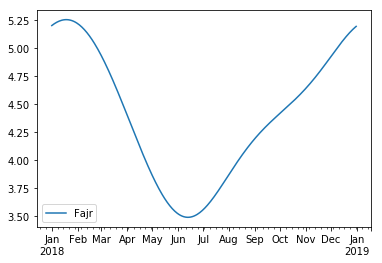

In [24]:
# df.reset_index().plot(x='index', y=df.Fajr)
plt.figure(figsize=(19,6));
df.plot(y='Fajr', use_index=True).plot(y='Shorouq', use_index=True);

In [27]:
x=df.reset_index()['index']
y1=df['Fajr']
y2=df['Shorouq']
y3=df['Zohr']
y4=df['Asr']
y5=df['Maghrib']
y6=df['Isha']

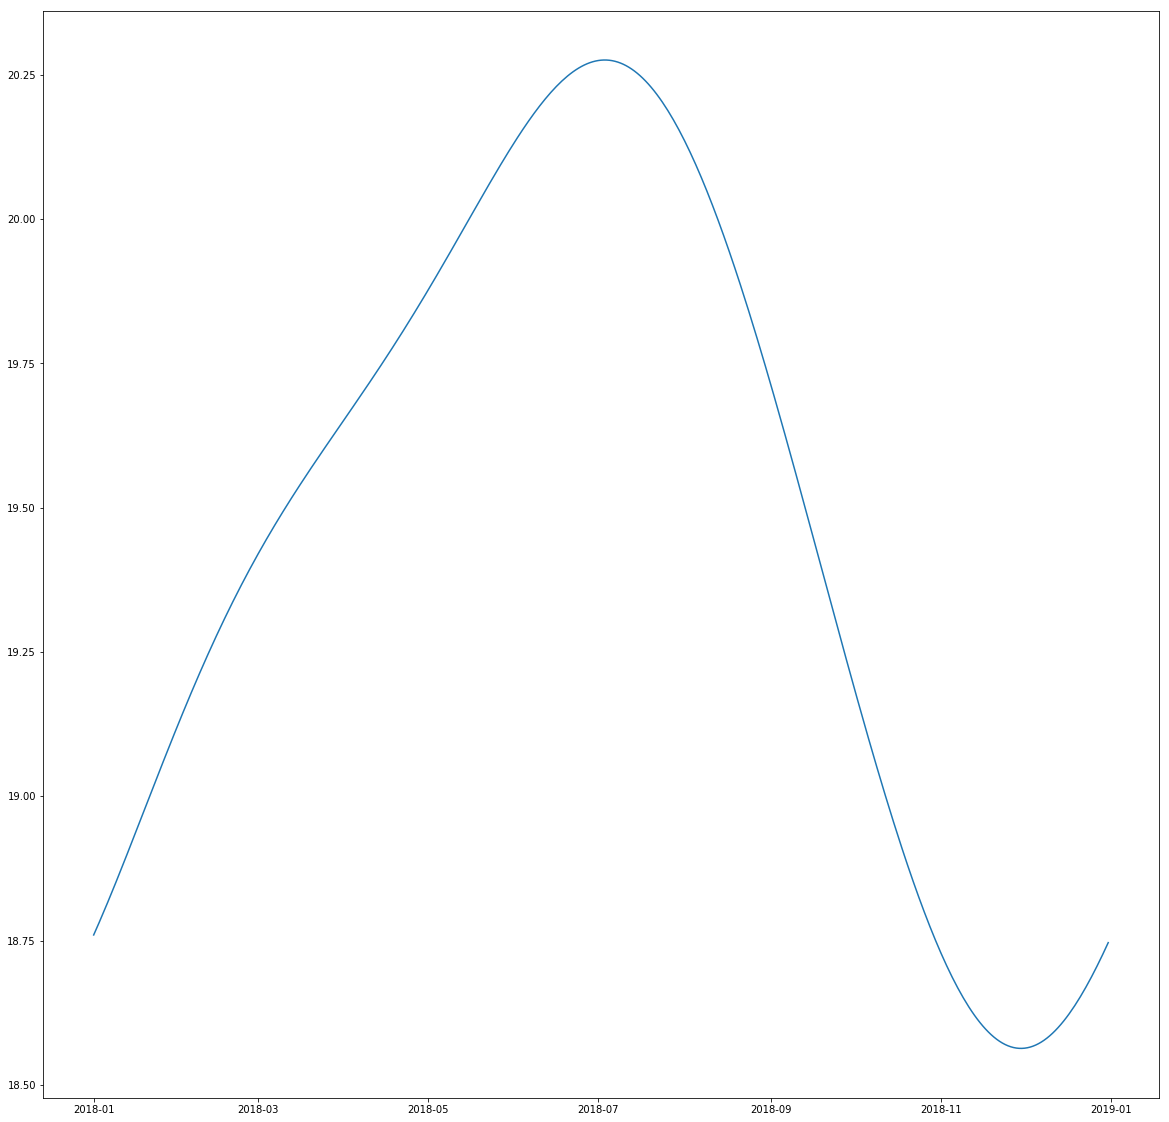

In [33]:
plt.figure(figsize=(20,20))
# for y in [y1, y2, y3, y4, y5, y6]:
#     plt.plot(x,y)
plt.plot(x,y6)

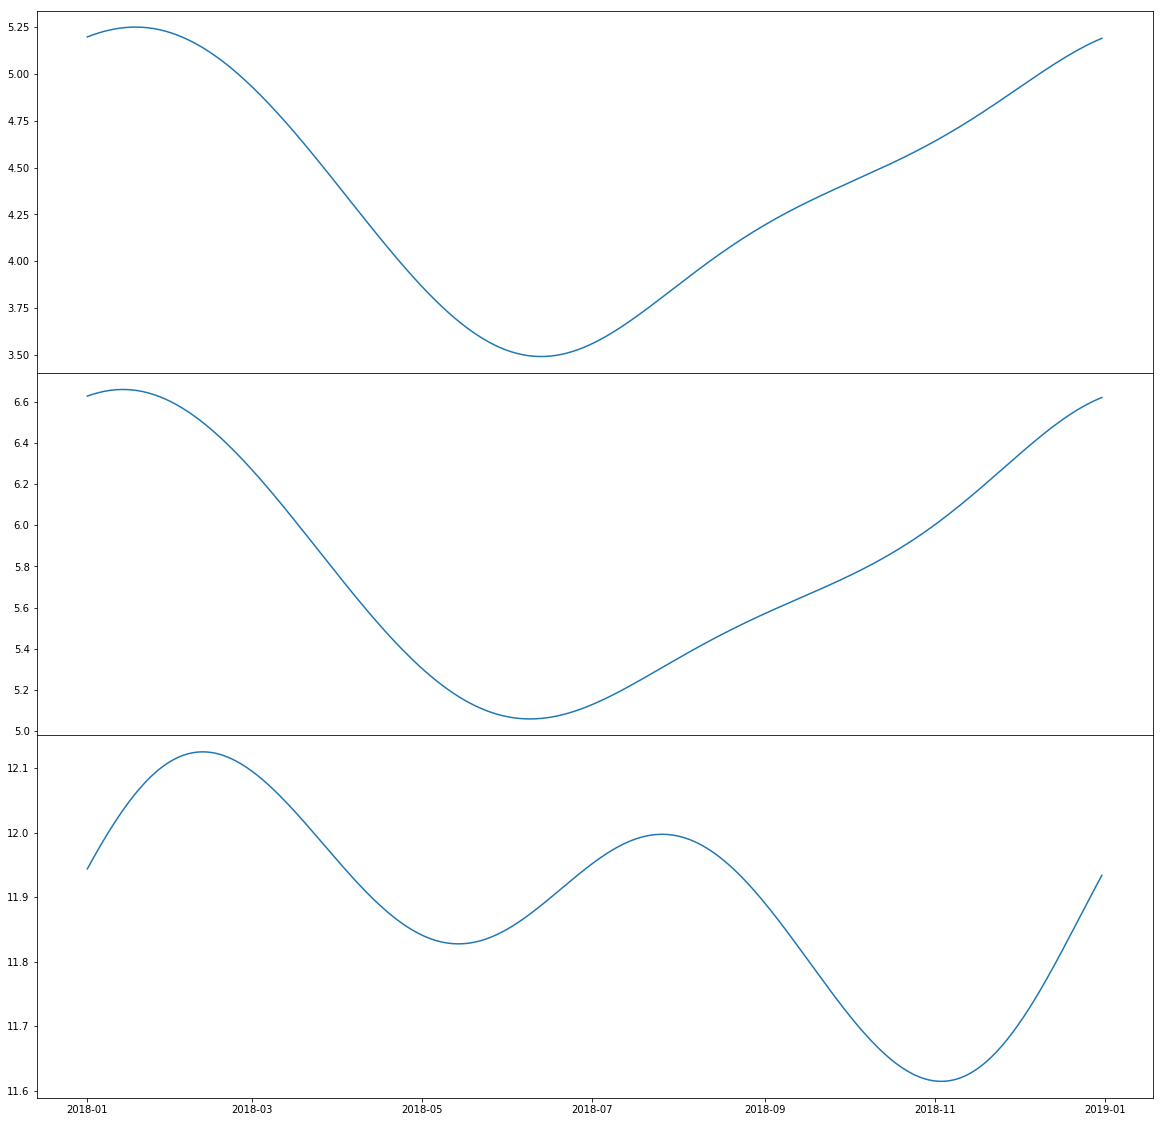

In [38]:
# plt.figure(figsize=(20,20))
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,20))#, sharey=True)
ax1.plot(x, y1)
# ax1.set_title('Sharing both axes')
ax2.plot(x, y2)
ax3.plot(x, y3)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

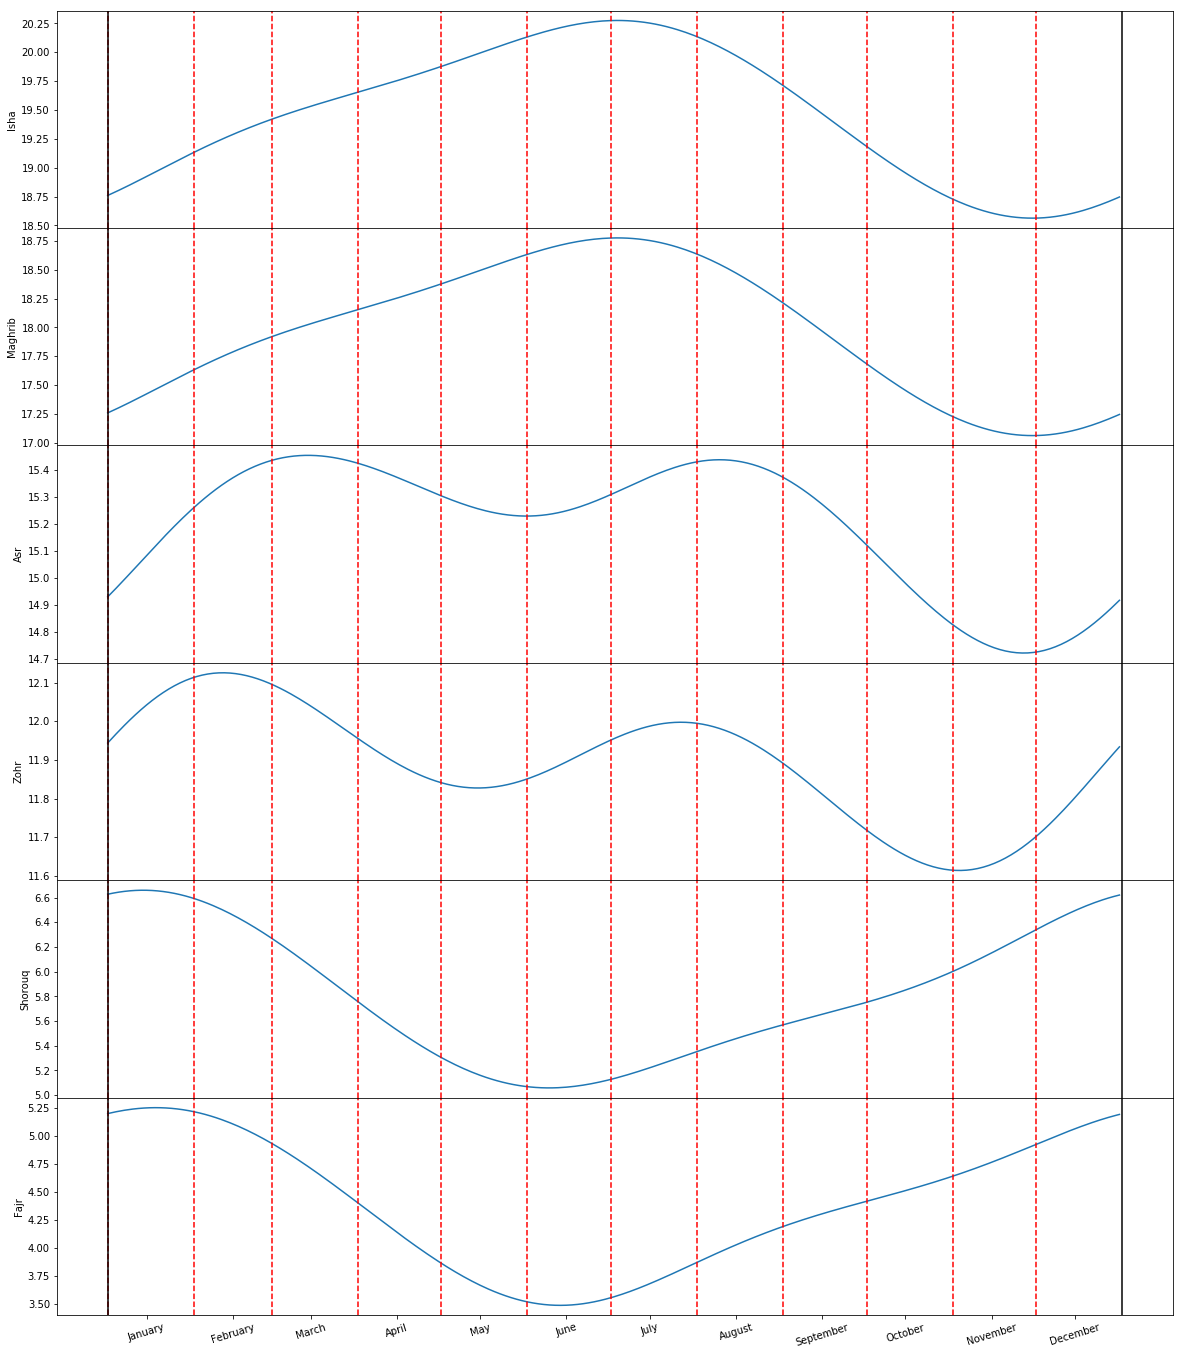

In [67]:
# plt.figure(figsize=(20,20))
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex=True, figsize=(20,24))#, sharey=True)
charts = (ax1, ax2, ax3, ax4, ax5, ax6)
pr_times= (y6, y5, y4, y3, y2, y1)
first_day = []
mid_day = []
for mon in range(1,13):
    first_day.append(date(year=2018,day=1,month=mon))
    mid_day.append(date(year=2018,day=15,month=mon))
for chart, pr_time in zip(charts, pr_times):
    chart.plot(x, pr_time)
    for day_tick in first_day:# in range(2,13):
        chart.axvline(day_tick, color='r', linestyle='--')
#         chart.axvline(date(year=2018,day=1,month=mon), color='r', linestyle='--')
    chart.axvline(date(year=2018,day=1,month=1), color='k', linestyle='-')
    chart.axvline(date(year=2019,day=1,month=1), color='k', linestyle='-')
for i, ax_n in enumerate(charts):
    ax_n.set_ylabel(col_names[::-1][i])
# plt.axvline(date(year=2018,day=2,month=2))
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0);
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False);
plt.xticks(mid_day, calendar.month_name[1:13], rotation=17 );

In [71]:
date(year=2012,day=2,month=2)
timedelta(hours=9.888888888888886)

datetime.timedelta(0, 35600)

In [74]:
td = timedelta(hours=9.888888888888886)
(datetime(2000,1,1)+td).strftime("%H:%M")

'09:53'

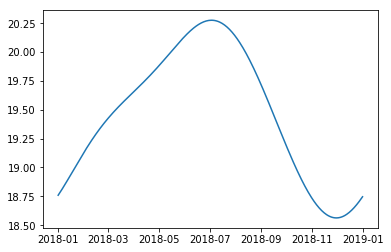

In [75]:
plt.plot(x,y6)

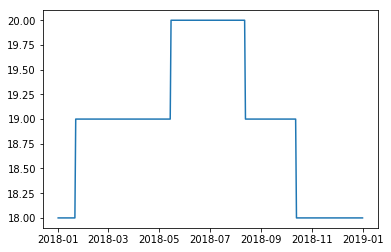

In [98]:
u6=np.array(y6)
v6=u6.astype('timedelta64[s]') 
# v6= timedelta(hours=u6)
# print(list(zip(u6, v6)))
plt.plot(x,v6)

In [99]:
from math import floor
def to_t_delt(number):
    return pd.to_timedelta(f'{floor(number)}hours {(number - floor(number)) * 100}min')
# hour_min = u6.applymap(to_t_delt)
hour_min = np.vectorize(to_t_delt)(u6)
hour_min[:5]

array([Timedelta('0 days 19:15:57.820620'),
       Timedelta('0 days 19:17:03.212460'),
       Timedelta('0 days 19:18:09.669240'),
       Timedelta('0 days 19:19:17.123759'),
       Timedelta('0 days 19:20:25.508640')], dtype=object)

In [100]:
# plt.plot(x,hour_min)

In [111]:
def format_time(x):
    '''
    convert hours to h:mm
    '''
    h=int(x)
    m=int((x-h)*60)
    if h>23:
        h=h%24
    return '{:01d}:{:02d}'.format(h,m)
format_time(235.598)

'19:35'

In [122]:
def is_at_5_minutes(x):
    '''
    Checks if the time is at 5 minutes interval
    input string at the format 'h:mm'
    Returns true or false
    '''
    mins = int(x.split(':')[1])
#     print (mins)
    if mins%5 ==0:
        return True
    else:
        return False
is_at_5_minutes('19:35'), is_at_5_minutes('19:33'), is_at_5_minutes('19:00')

(True, False, True)

In [121]:
np.array(list(range(0,60,5)))/60

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667])

In [159]:
# from matplotlib.ticker import FuncFormatter
# import matplotlib.ticker
def format_func(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)

    return "{:d}:{:02d}".format(hours, minutes)
    # return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)

    
# formatter = FuncFormatter(format_func) 


def format_func_h(x, pos):
    h=int(x)
    m=int((x-h)*60)
    if h>23:
        h=h%24
    return '{:01d}:{:02d}'.format(h,m)
    # return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)


formatter = FuncFormatter(format_func_h)

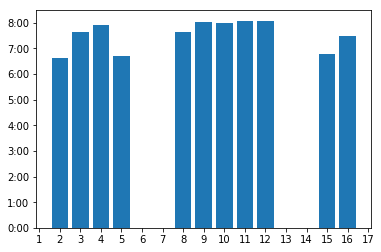

In [156]:
time_list = [timedelta(0, 23820), timedelta(0, 27480), 
             timedelta(0, 28500), timedelta(0, 24180), 
             timedelta(0, 27540), timedelta(0, 28920), 
             timedelta(0, 28800), timedelta(0, 29100), 
             timedelta(0, 29100), timedelta(0, 24480), 
             timedelta(0, 27000)]
labels = [2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16]
seconds = [i.seconds for i in time_list]
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.bar(labels, seconds)

ax.yaxis.set_major_formatter(formatter)
# this locates y-ticks at the hours
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=3600))
# this ensures each bar has a 'date' label
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))

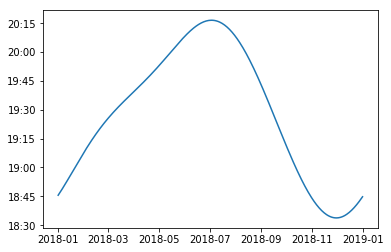

In [160]:
f, ax = plt.subplots(1);
# seconds = [float(int(h)*3600.+(h-int(h))*60.)  for h in y6]
# seconds = [float(int(h)*60.+(h-int(h))*1.)  for h in y6]
seconds=y6
seconds
ax.plot(x,seconds);
# ax.plot(x,y6);
ax.yaxis.set_major_formatter(formatter)
# this locates y-ticks at the hours
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1500))
ax.yaxis.set_major_locator(matplotlib.ticker.AutoLocator())
# this ensures each bar has a 'date' label
# ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=30))
# ax.plot(x,y6);

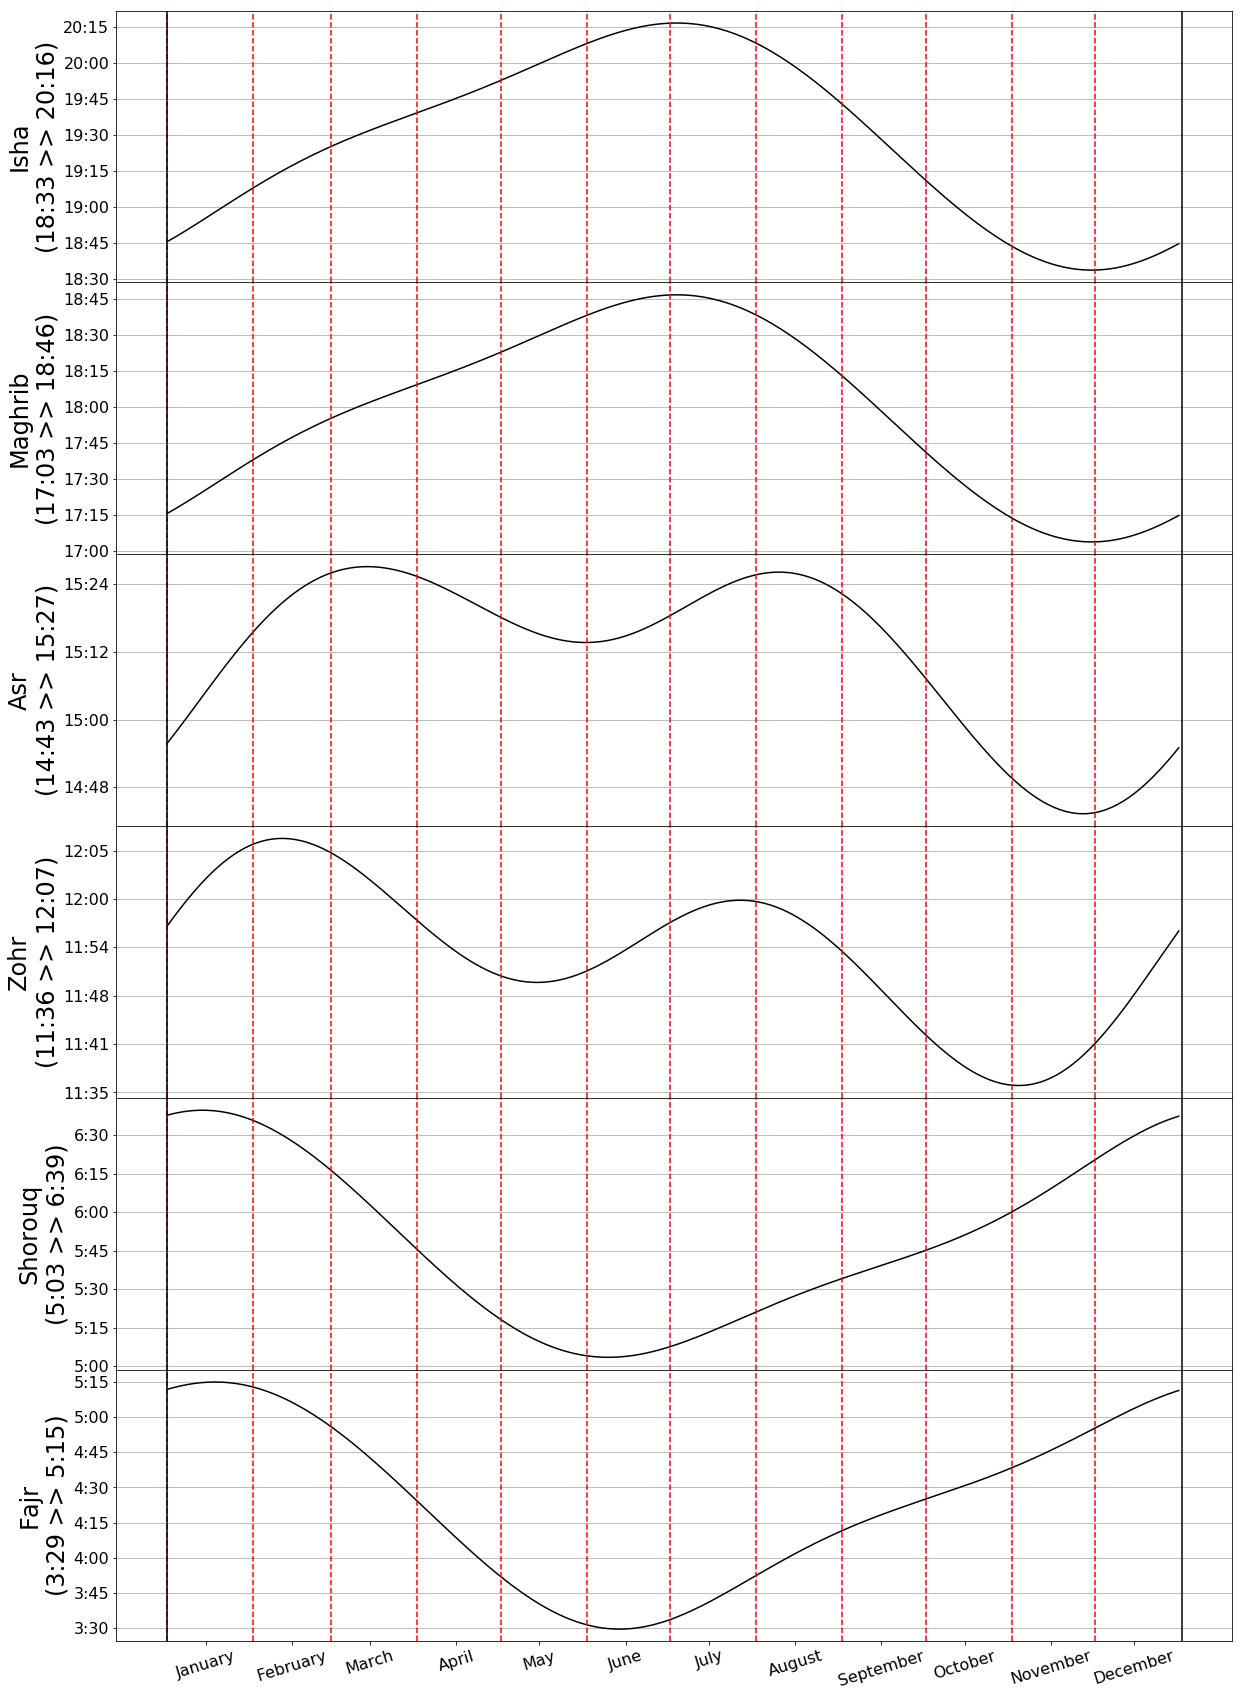

In [189]:
# plt.figure(figsize=(20,20))
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex=True, figsize=(20,30))#, sharey=True)
charts = (ax1, ax2, ax3, ax4, ax5, ax6)
pr_times= (y6, y5, y4, y3, y2, y1)
# for pr in pr_times:
#     print(format_time(min(pr)), format_time(max(pr)))
def pray_time_range(pr):
    return '\n({} >> {})'.format(format_time(min(pr)), format_time(max(pr)))
    pass
first_day = []
mid_day = []
for mon in range(1,13):
    first_day.append(date(year=2018,day=1,month=mon))
    mid_day.append(date(year=2018,day=15,month=mon))
for chart, pr_time in zip(charts, pr_times):
    chart.plot(x, pr_time, color='k')
    for day_tick in first_day:# in range(2,13):
        chart.axvline(day_tick, color='r', linestyle='--')
#         chart.axvline(date(year=2018,day=1,month=mon), color='r', linestyle='--')
    chart.axvline(date(year=2018,day=1,month=1), color='k', linestyle='-')
    chart.axvline(date(year=2019,day=1,month=1), color='k', linestyle='-')
    chart.yaxis.set_major_formatter(formatter)
#     chart.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1500))
    chart.yaxis.set_major_locator(matplotlib.ticker.AutoLocator())
    chart.grid(axis='y')
    chart.tick_params(axis='both', which='major', labelsize=16)
for i, ax_n in enumerate(charts):
    prayer_name = col_names[::-1][i]
    prayer_range = pray_time_range(pr_times[i])
    ax_n.set_ylabel(prayer_name + prayer_range, size=24)
# plt.axvline(date(year=2018,day=2,month=2))
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0);
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False);
plt.xticks(mid_day, calendar.month_name[1:13], rotation=17);

# plt.savefig('PrayerTimesForRiyadh.png', bbox_inches='tight')
# plt.savefig('PrayerTimesForRiyadh.pdf', bbox_inches='tight')